In [881]:
# Dubbi:
#1 come mai le chiavi di a sembrano random?
#2 come faccio a non fare re-inserimento ?? Ricorda io estraggo d-1 cosi, più uno, più un altro che è quello di arrivo

In [980]:
import OffsetArrays
using Plots
using Revise
include("functions.jl")

rand_disorder (generic function with 1 method)

In [927]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected

λ = 0.1 #infection rate
d = 3 # degree (fixed for now) 
T = 20 # discrete time
γ = 0.05 # autoinfection probability
N = 500; #population size

In [928]:
xi0,sij,sji = rand_disorder(γ,λ)

(0, 1, 13)

# Population dynamics for the messages

In [929]:
# Creation of the population
# we create μ as the set of all the N functions
# μ[k,ti,ck,τi,σk] is the value taken by the
# function μk with arguments ti,ck,τi,σk
# Using OffsetArrays we managed to keep notation 
# coherent with the notes: 

# i=1,...,N, 
# ti=0,...,T+1 
# c = 0,1
# σ=0,1,2

# The same is done for the ν function later
inizialization = ones(N,T+2,2,T+2,3) / (6*(T+2)^2)
μ = OffsetArrays.OffsetArray(inizialization,0,-1,-1,-1,-1);

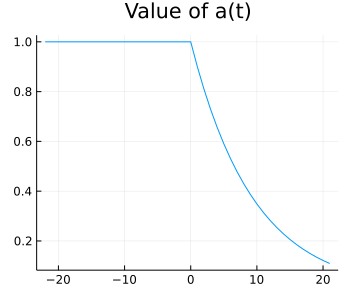

In [930]:
#Precalculation of the function a := (1-λ)^{tθ(t)}, 
#useful for later (the function a appears
#  in the inferred time factor node)

a = Dict(zip(-T-2:T+1,[ t<=0 ? 1 : (1-λ)^t for t = -T-2:T+1]));
μold = copy(μ);
plot(LinRange(-T-2,T+1,2T+4),[a[t] for t=-T-2:T+1],size=(350,300),legend=false,title="Value of a(t)")

In [931]:
ν = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1);
neighbours = rand(1:N,d-1);

In [932]:
tot_iterations = 50000
for iterations = 1:tot_iterations
    # Extraction of disorder: state of individual i: xi0, delays: sij and sji

    xi0,sij,sji = rand_disorder(γ,λ)

    # Initialization of ν=0
    ν = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)

    #Extraction of d-1 μ's from population
    neighbours = rand(1:N,d-1)

    #Beginning of calculations: we start by calculating the ν: 
    calculate_ν!(ν,μ,neighbours,xi0,T)
    
    # Now we use the ν vector just calculated to extract the new μ.
    # We extract a population index that we call "l".
    # We overwrite the μ in postition μ[l,:,:,:,:]
    l = rand(1:N);

    # First we calculate and store the cumulated of ν with respect to 
    # planted time, i.e. the third argument. We call Σ this cumulated 
    Σ = cumsum(ν,dims=3)
    update_μ!(μ,ν,Σ,l,sij,sji,T)     
end

#p1=plot(Σe(sum(μ,dims=1) ./ N,864))
#p1=plot!(reshape(sum(μold,dims=1) ./ N,864))
#μold = copy(μ);
#plot(p1)

LoadError: InterruptException:

Once the convergence has been studied we plot the heatmaps of the messages

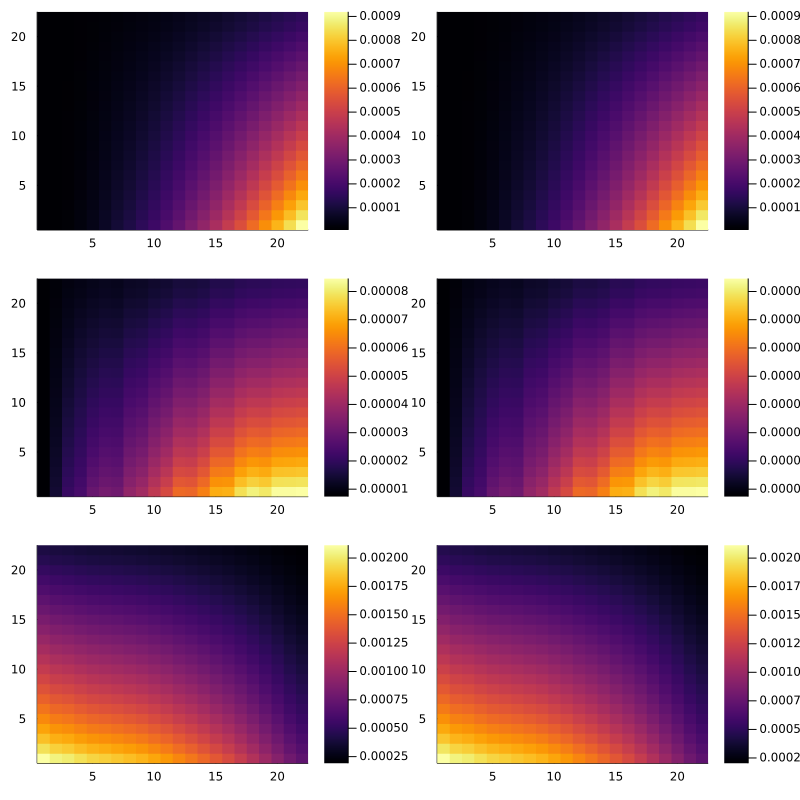

In [933]:
pl1 = heatmap(reshape(sum(μ,dims=1)[:,:,0,:,0] ./ N,T+2,T+2))
pl2 = heatmap(reshape(sum(μ,dims=1)[:,:,1,:,0] ./ N,T+2,T+2))
pl3 = heatmap(reshape(sum(μ,dims=1)[:,:,0,:,1] ./ N,T+2,T+2))
pl4 = heatmap(reshape(sum(μ,dims=1)[:,:,1,:,1] ./ N,T+2,T+2))
pl5 = heatmap(reshape(sum(μ,dims=1)[:,:,0,:,2] ./ N,T+2,T+2))
pl6 = heatmap(reshape(sum(μ,dims=1)[:,:,1,:,2] ./ N,T+2,T+2))

plot(pl1,pl2,pl3,pl4,pl5,pl6,layout = (3,2),size = (800,800))

In [934]:
sum(ν[0,0,:,2]) 

0.0010885530538081022

In [935]:
sum(μ[:,0,1,0,1])

0.03684573002754821

# From messages to marginals

In [985]:
marg = OffsetArrays.OffsetArray(zeros(N,T+2,T+2),0,-1,-1);
ν1 = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)
ν2 = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)
max_count = 1000;

In [986]:
# Now we take out converged population of μ and use it to extract marginals.
# First we extract two ν's and then we combine it in order to obtain a marginal.
# In order to extract a ν we have to extract d-1 μ's. Therefore we extract two groups of 
# d-1 μ's and from them we calculate the two ν's. We also have to extract disorder.
for _ = 1:max_count
    group1 = rand(1:N,d-1) #groups of neighbours 
    group2 = rand(1:N,d-1)
    
    xi0,sij,sji = rand_disorder(γ,λ) #disorder
    xj0 = Int(rand() < γ);
        
    calculate_ν!(ν1,μ,group1,xi0,T)
    calculate_ν!(ν2,μ,group2,xj0,T)
    Σ = cumsum(ν2,dims=3) #calculation of the two ν's
    
    l = rand(1:N)

    #Once the ν's are calculated we calculate the marginals
    update_marginal!(marg,l,ν1,ν2,Σ,sij,sji,T)
    
end
#heatmap(reshape((marg[l,:,:]),12,12),xlabel="planted",ylabel="inferred",title="One RANDOM marginal")

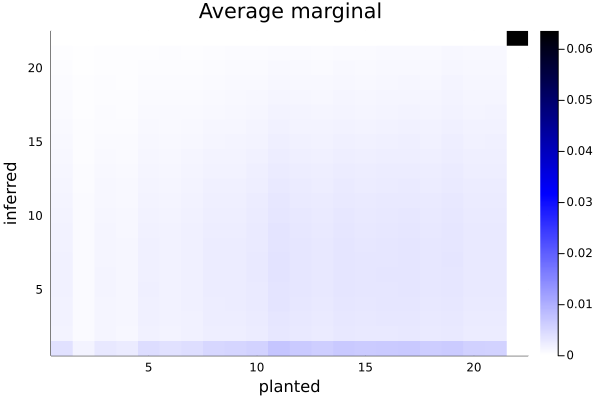

In [988]:
heatmap(marg2D,c=[:white,:blue,:black],xlabel="planted",ylabel="inferred",title="Average marginal")

In [987]:
marg2D = reshape((sum(marg,dims=1)./ max_count),T+2,T+2)

22×22 Matrix{Float64}:
 0.00372875   0.00143613   …  0.00569913   0.00562954   0.0
 0.00154468   0.000562702     0.00241132   0.00237513   0.0
 0.00162487   0.000597123     0.00255154   0.00252292   0.0
 0.00168296   0.000624284     0.00266114   0.00264165   0.0
 0.00171716   0.00064317      0.0027373    0.00272747   0.0
 0.00172615   0.000652947  …  0.00277792   0.00277744   0.0
 0.00170942   0.000653099     0.00278193   0.00278983   0.0
 0.00166745   0.000643516     0.00274962   0.00276443   0.0
 0.00160189   0.00062454      0.00268267   0.00270267   0.0
 0.00151541   0.000596958     0.00258413   0.00260754   0.0
 0.00141163   0.000561954  …  0.00245824   0.00248349   0.0
 0.00129482   0.000521023     0.00231011   0.00233603   0.0
 0.00116957   0.000475854     0.00214539   0.00217132   0.0
 0.00104048   0.000428214     0.00196984   0.00199573   0.0
 0.000911861  0.000379817     0.00178902   0.00181537   0.0
 0.000787457  0.000332223  …  0.00160794   0.0016357    0.0
 0.000670321  0.0

In [978]:
sum(marg2D)

0.891

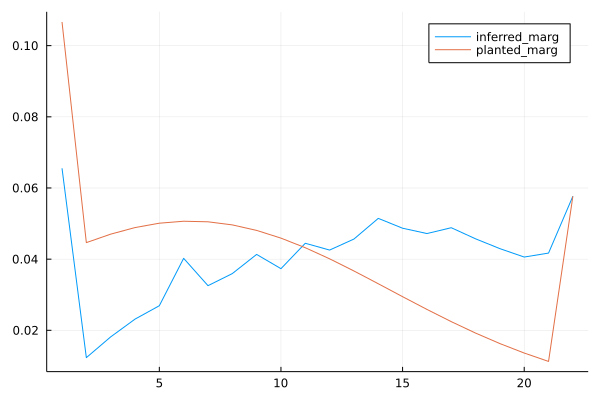

In [977]:
plot(sum(marg2D,dims=1)',label="inferred_marg")
plot!(sum(marg2D,dims=2),label="planted_marg")

In [979]:
sum(marg2D)

0.891